#Problème:

#Deux cas d'utilisation des données d'opportunité

La qualité de la description d'un phénomène physique dépend des moyens d'observation disponibles. Généralement, les moyens à disposition dépendent de la zone géographique et de la période considérée.
Lorsque les capteurs sont peu nombreux, on peut chercher à compléter l'observation par des données supplémentaires issues de capteurs non spécifiques. On parle alors de *données d'opportunité*.

Les *données d'opportunité* peuvent être exploitées par apprentissage. Une approche courante consiste à entraîner un modèle sur la zone où des capteurs spécifiques peuvent fournir une cible de qualité. Le modèle est ensuite porté là où seules les *données d'opportunité* sont disponibles.

Aujourd'hui, on utilise par exemple des données issues des réseaux de télécommunication pour préciser la localisation et l'intensité de phénomènes physiques ou sociaux.  
La première partie du problème est inspirée du cas où la donnée opportune est une atténuation du signal échangé entre les antennes d'un réseau mobile.

On cherche aussi à exploiter des données issues de capteurs de mauvaise qualité qui peuvent être beaucoup plus nombreux que les capteurs spécifiques. C'est ce qu'illustre la seconde partie.

**Note**: les deux parties du problème sont complètement indépendantes.

**Partie I - problème n°1 : régression avec un UNet**

In [20]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Lien valable jusqu'au 17/01/2024:
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
! mkdir data
from utile_BE import *

--2024-01-09 11:48:45--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402 (27K) [application/octet-stream]
Saving to: ‘HAnmgiuVNGn_XtdcYCeMNnJ’

HAnmgiuVNGn_XtdcYCe 100%[===================>]  26.76K  --.-KB/s    in 0s      

2024-01-09 11:48:47 (198 MB/s) - ‘HAnmgiuVNGn_XtdcYCeMNnJ’ saved [27402/27402]

mkdir: cannot create directory ‘data’: File exists


Dans ce problème, la cible $T$ est un champ physique scalaire, positif ou nul. On suppose que, dans le meilleur des cas, deux types de capteurs spécifiques sont disponibles.\
Le premier type fournit une mesure spatialisée du champ. Il n'est pas partout disponible. Le second type de capteur fournit une mesure ponctuelle. Ces capteurs sont implantés sur toute la zone d'intérêt mais il ne couvrent correctement que 0.5% de la surface.\
En plus de ces capteurs, on suppose qu'on a accès à des données issues d'un réseau de télécommunications. Ces données réflètent l'atténuation d'un signal échangé entre des antennes relais. On suppose que pour chaque signal émis entre deux antennes $A_i$, $A_j$, on peut calculer une quantité $S(A_i,A_j;T)$ qui ne dépend que de la valeur moyenne du champ $T$ sur le trajet entre $A_i$ et $A_j$.

On se place dans le cas où un jeu est constitué sur la zone où la mesure spatialisée du champ est disponible. Pour une première preuve de concept, on travaille avec des images de synthèse sur lesquelles:
- les mesures ponctuelles ont été attribuées aux pixels qui leur correspondent.
- les données d'opportunité sont représentées par des segments. Les extrémités d'un segment représentent deux antennes $A_i$, $A_j$. Le long d'un segment, l'intensité des pixels est constante, de valeur $S(A_i,A_j;T)$ (seule exception, dans le cas d'intersections, les valeurs sont simplement sommées - voir ci-dessous).

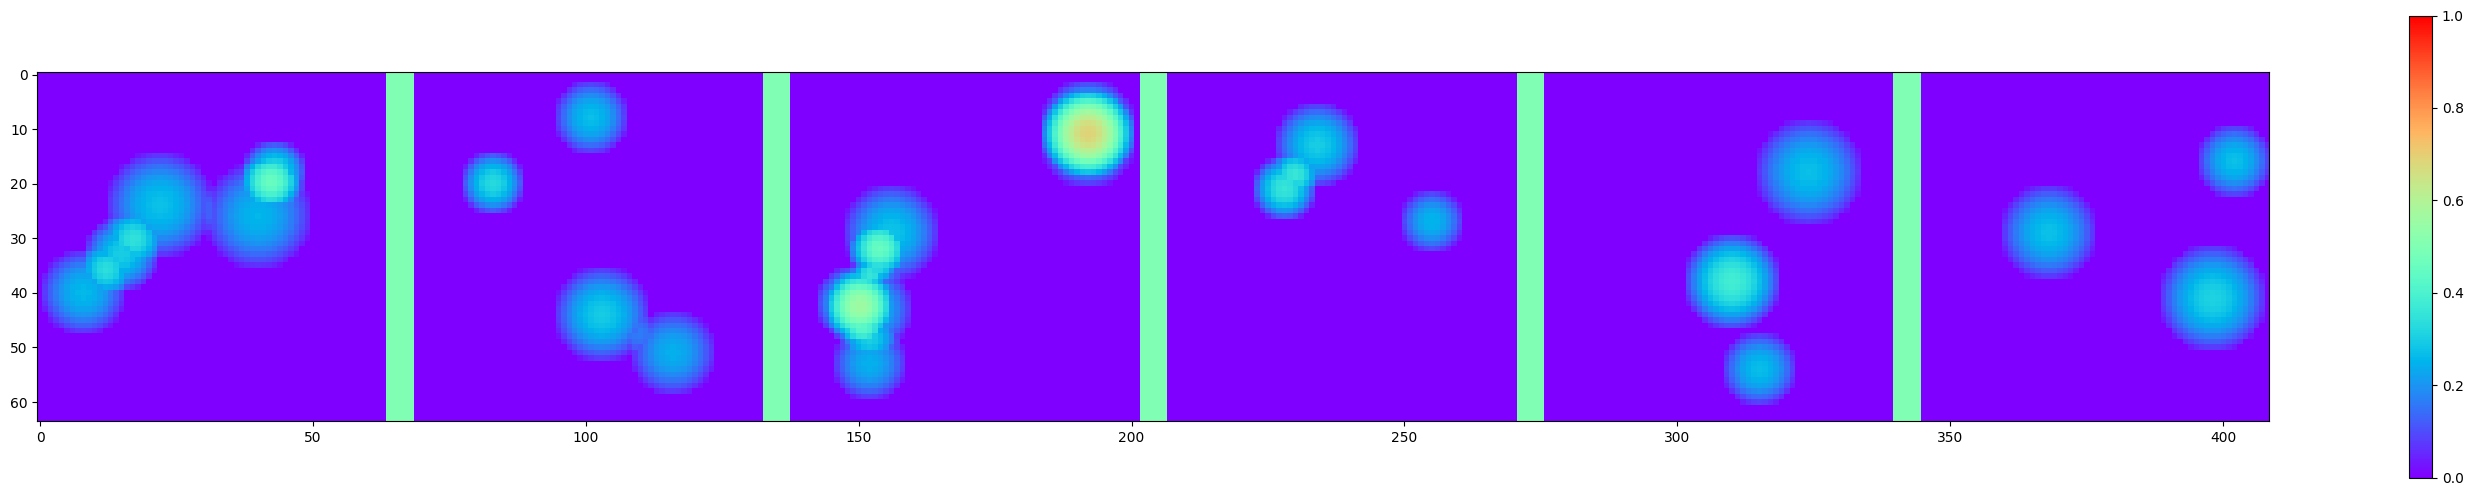

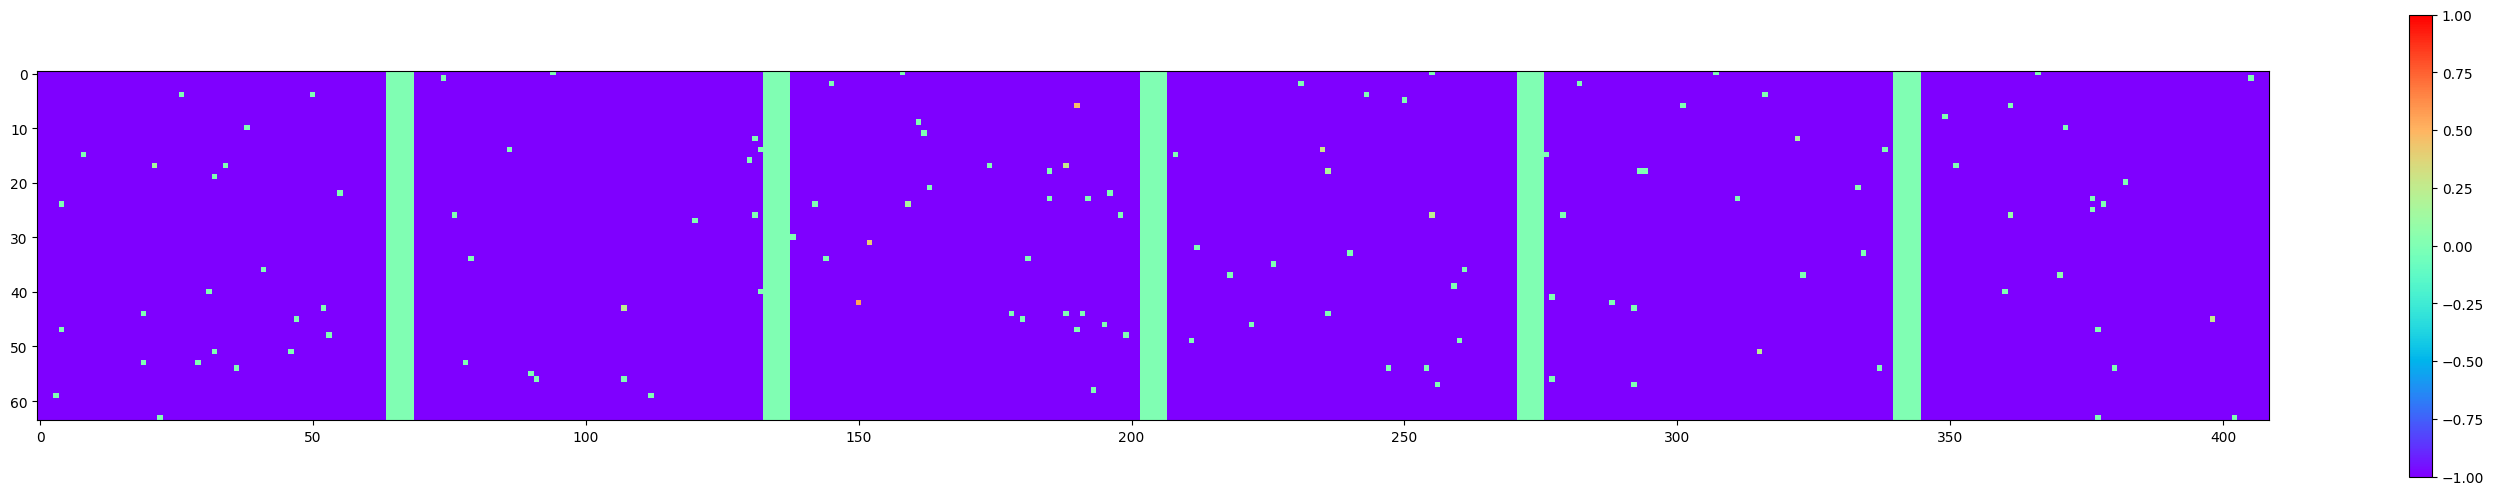

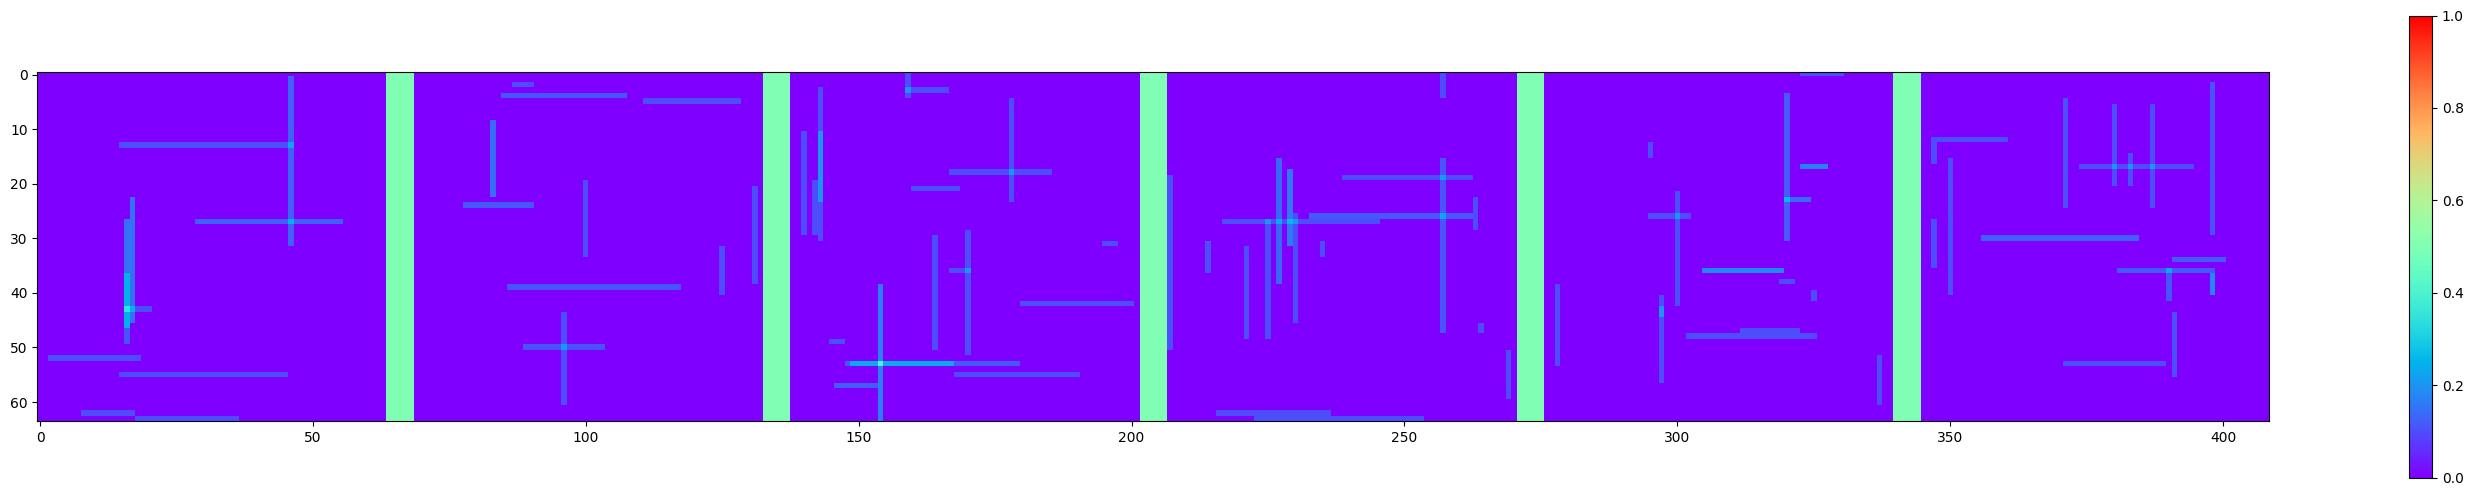

In [22]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-1, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

Dans la cellule précédente, la fonction *gen_image_with_integrated_signals* permet de visualiser le jeu simulé:
- *full_target* représente le champ $T$ vu par le premier type de capteur spécifique sur la zone couverte par l'image. Il s'agit de disques de valeurs positives.
- *partial_target* représente les mesures ponctuelles. En dehors des points de mesure, la valeur est fixée à -1.
- *integrated_signals* contient la représentation par segments. En dehors des segments, la valeur est fixée à 0. Dans cette simulation simpliste, les segments ont tous été supposés parallèles à l'un des deux côtés de l'image. De plus, $S$ a été modélisé comme une fonction affine, croissante de la valeur moyenne sur le segment. Ainsi, l'intensité d'un segment croit avec le nombre de disques traversés.

Dans cette partie, le but est de dire:\
**A.** si l'on peut entraîner avec succès un *FCN* à restituer $T$ **à partir** de données d'opportunité représentées par des segments (**exercice 1**).\
**B.** si en combinant des données d'opportunité aux mesures ponctuelles, on améliore bien les performances d'un $FCN$ (**exercice 2**).

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [23]:
ch_in = 1 # because we have only one channel in the input image (integrated_signals which are the opportunity data)
ch_out = 1 # because we have only one channel in the output image (the temperature)
size = 8 # which is the network size parameter (the number of layers), indeed the network is a U-Net with 8 layers because the image is 256x256 and the size of the image is divided by 2 at each layer

fcn = UNet(ch_in, ch_out, size).cuda()

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [24]:
# how many weights this unet contains ?
print("number of weights in the network:", sum([np.prod(p.size()) for p in fcn.parameters()]))

number of weights in the network: 232546


**Q3** Présenter brièvement les types de couches utilisées dans ce réseau.

In [25]:
# Pour voir les noms des couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

UNet
inconv
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
outconv
Conv2d
outconv
Conv2d


On y trouve :
- des couches de convolution 2d (Conv2d) qui permettent d'extraire des features de l'image d'entrée. Ces couches sont caractérisées par des noyaux (kernels) qui contiennent les poids (un neurone = un noyau). Pour UNet, chaque noyau, passé sur l'image d'entrée, fournit une carte de features de dimensions spatiales égales.
- des couches de max pooling 2d (MaxPool2d) qui permettent de réduire la dimension spatiale des cartes de features, en prenant le maximum sur des fenêtres de taille 2x2, canal par canal.
- des couches de transposition de convolution 2d (ConvTranspose2d) qui permettent d'augmenter la dimension spatiale des cartes de features, en appliquant un noyau de taille 2x2, canal par canal.
- des fonctions d'activation  non linéaires (ReLU) qui permettent d'introduire de la non linéarité dans le réseau.

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne (MAE).

In [26]:
def criterion(output,target):
  # return MAE
  return torch.mean(torch.abs(output-target))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [27]:
torch.manual_seed(0)
# instantiate adam with a learning rat eof 0.0002
optimizer = optim.Adam(fcn.parameters(), lr=2*10**(-4))

**Q6** Pourquoi est-il, en général, nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?

Il est en général nécessaire de passer par une étape de validation lors d'un apprentissage pour éviter le sur-apprentissage. En effet, si on ne dispose pas d'une étape de validation, on risque de sur-apprendre les données d'entraînement et donc de ne pas généraliser correctement sur les données de test.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époque : 30
- batches par époque : 100
- taille de batch : 32

In [28]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size, p)


        input = integrated_signals.cuda()
        target = full_target.cuda()

        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.34975213
Epoch 1
epoch loss : 

0.18681955
Epoch 2
epoch loss : 

0.15001987
Epoch 3
epoch loss : 

0.12217073
Epoch 4
epoch loss : 

0.10252512
Epoch 5
epoch loss : 

0.09280696
Epoch 6
epoch loss : 

0.084923856
Epoch 7
epoch loss : 

0.08035209
Epoch 8
epoch loss : 

0.07464602
Epoch 9
epoch loss : 

0.06623879
Epoch 10
epoch loss : 

0.06505748
Epoch 11
epoch loss : 

0.062184907
Epoch 12
epoch loss : 

0.060722485
Epoch 13
epoch loss : 

0.056910254
Epoch 14
epoch loss : 

0.052973915
Epoch 15
epoch loss : 

0.048724376
Epoch 16
epoch loss : 

0.045524098
Epoch 17
epoch loss : 

0.042738255
Epoch 18
epoch loss : 

0.04267977
Epoch 19
epoch loss : 

0.040701922
Epoch 20
epoch loss : 

0.040557824
Epoch 21
epoch loss : 

0.039496135
Epoch 22
epoch loss : 

0.03902707
Epoch 23
epoch loss : 

0.039460547
Epoch 24
epoch loss : 

0.039088182
Epoch 25
epoch loss : 

0.03726294
Epoch 26
epoch loss : 

0.039082013
Epoch 27
epoch loss : 

0.038354807
Epoch 28
epoch 

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

Text(0.5, 1.0, "Courbe d'apprentissage")

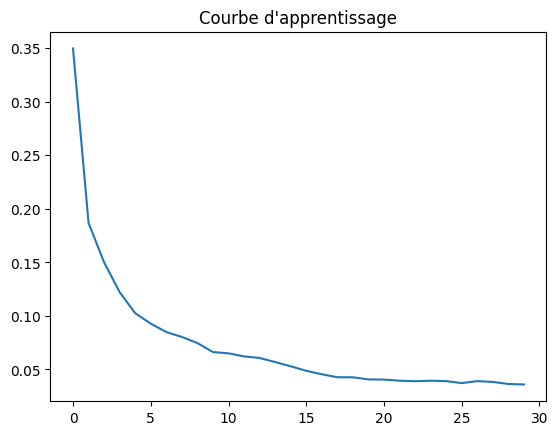

In [29]:
plt.plot(train_losses)
plt.title("Courbe d'apprentissage")

In [30]:
# Visualisation des résultats

fcn.eval()
batch_size_test = 3

full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size_test, p)

input = integrated_signals.cuda()
output = fcn(input)

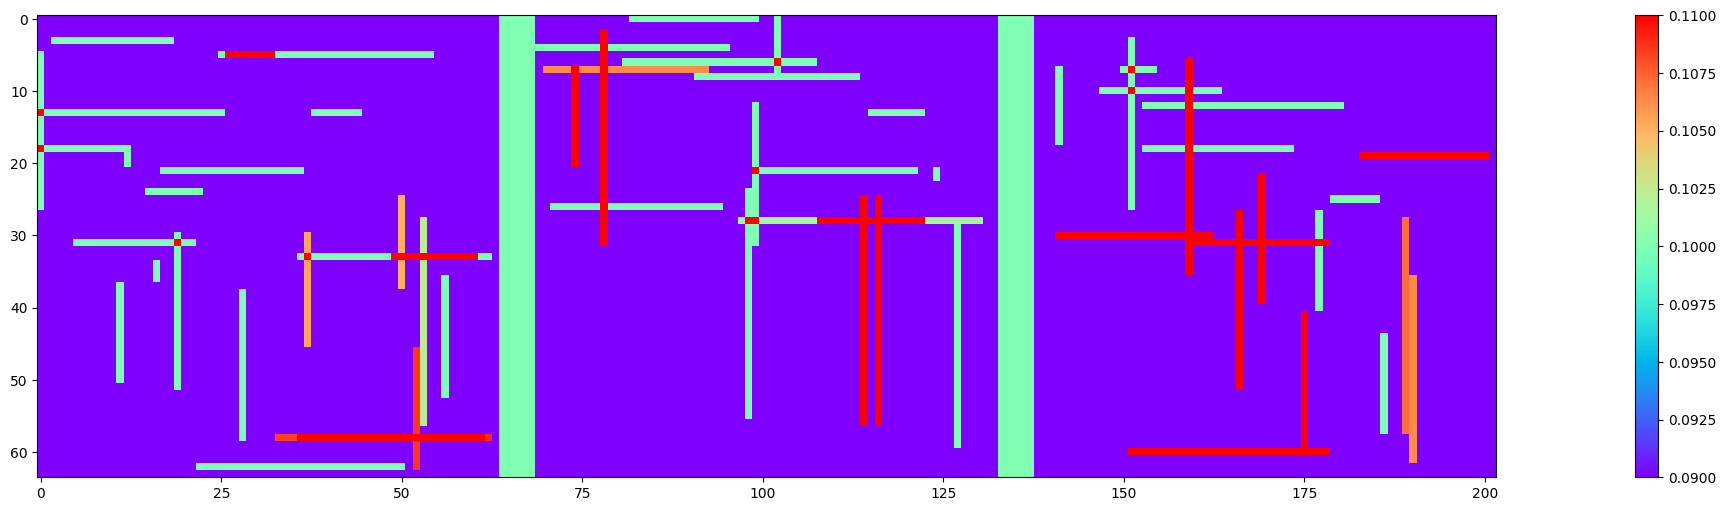

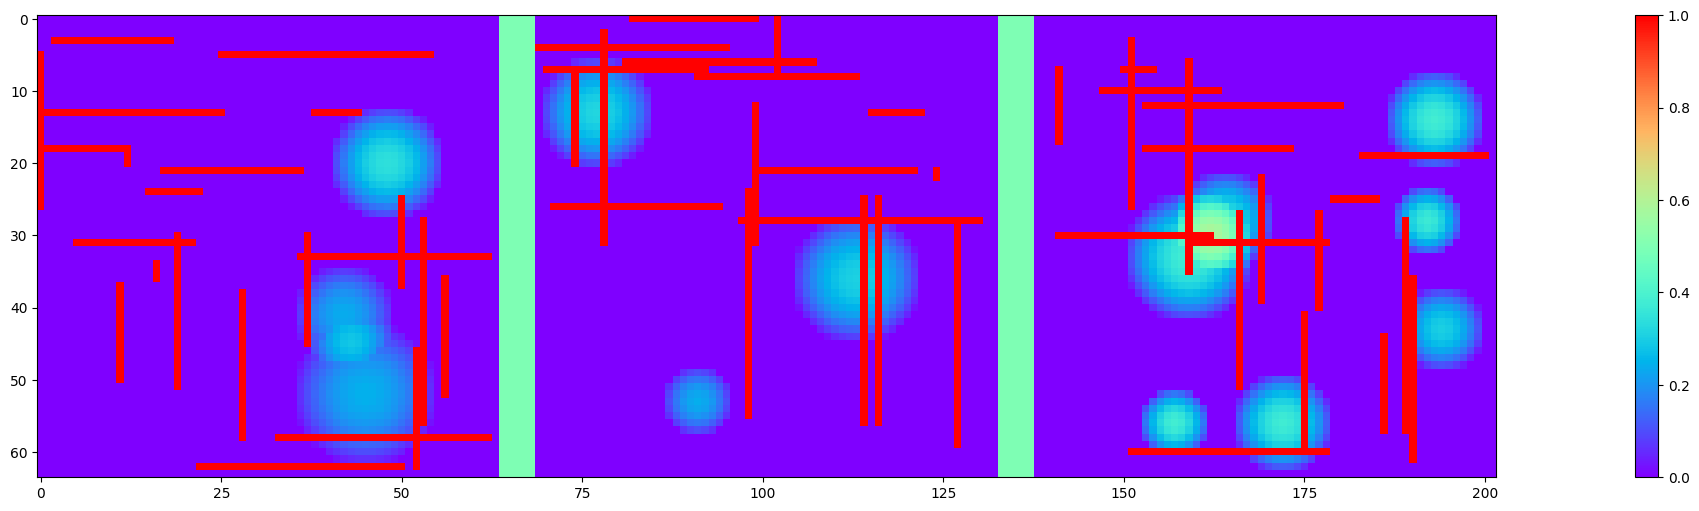

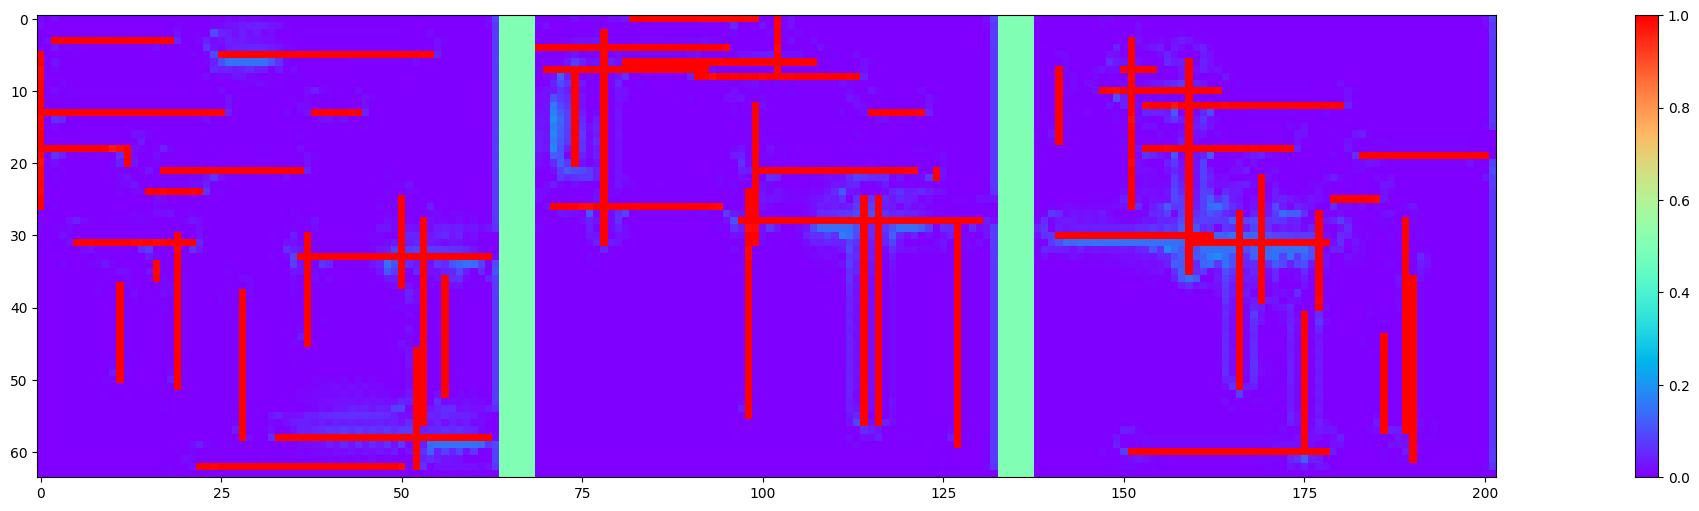

In [31]:
# première ligne : données d'opportunité
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input.detach().cpu(), batch_size_test, fig, k=0, min_scale=0.09, max_scale=0.11)

# deuxième ligne : température réelle
fig = plt.figure(1, figsize=(36, 6))
voir_batch2D(full_target.detach().cpu() + (input.detach().cpu()*10), batch_size_test, fig, k=0, min_scale=0, max_scale=1)

# troisième ligne : température prédite
fig = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu() + (input.detach().cpu()*10), batch_size_test, fig, k=0, min_scale=0, max_scale=1)

Concernant le point A, on peut dire qu'à 30 epochs, l'apprentissage n'est pas terminé, mais le réseau a déjà appris à former des plages de valeurs de T, notamment :
- sous les segments les plus intenses
- évitant les segments les moins intenses (ceux de valeur nulle)
- discoides lorsque plusieurs segments se croisent

Cependant,
- le réseau ne tient pas assez compte des segments qui traduisent une valeur moyenne faible mais non nulle.
- les artefacts sont encore nbreux (traces linéaires au sein des plages).

Une conséquence de la MAE, comparée à la MSE, c'est d'éviter un bruit strictement positif dans les zones où les segments sont absents (médiane conditionnelle nulle).

Note : la médiane conditionnelle au signal d'entrée n'a pas de raison d'être structurée en disques. Des disques ne sont attendus que dans la situation où le problème peut être inversé (par ex, aux endroits où les signaux d'entrée sont nbreux).


**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure.

In [32]:
# Apprentissage avec les données ponctuelles seules:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [33]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses_pt = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, _ = gen_image_with_integrated_signals(batch_size, p)


        input = partial_target.cuda()
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_pt.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.1282132
Epoch 1
epoch loss : 

0.057984065
Epoch 2
epoch loss : 

0.04897942
Epoch 3
epoch loss : 

0.04477199
Epoch 4
epoch loss : 

0.041849323
Epoch 5
epoch loss : 

0.04069832
Epoch 6
epoch loss : 

0.04126097
Epoch 7
epoch loss : 

0.040081073
Epoch 8
epoch loss : 

0.03854292
Epoch 9
epoch loss : 

0.037931554
Epoch 10
epoch loss : 

0.03785254
Epoch 11
epoch loss : 

0.036941793
Epoch 12
epoch loss : 

0.036592007
Epoch 13
epoch loss : 

0.038053382
Epoch 14
epoch loss : 

0.03653679
Epoch 15
epoch loss : 

0.035004396
Epoch 16
epoch loss : 

0.035549663
Epoch 17
epoch loss : 

0.035078686
Epoch 18
epoch loss : 

0.03567989
Epoch 19
epoch loss : 

0.03526594
Epoch 20
epoch loss : 

0.03630463
Epoch 21
epoch loss : 

0.03525419
Epoch 22
epoch loss : 

0.034149576
Epoch 23
epoch loss : 

0.034417562
Epoch 24
epoch loss : 

0.034717437
Epoch 25
epoch loss : 

0.033800494
Epoch 26
epoch loss : 

0.03401193
Epoch 27
epoch loss : 

0.033376325
Epoch 28
epoch l

In [34]:
# Apprentissage avec les deux champs en entrée:
ch_in = 2
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 30
nbatches = 100
batch_size = 32
p = 0.5 / 100
train_losses_2ch = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals =\
                       gen_image_with_integrated_signals(batch_size, p)


        input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_2ch.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)


Epoch 0
epoch loss : 

0.14185224
Epoch 1
epoch loss : 

0.05996783
Epoch 2
epoch loss : 

0.048268415
Epoch 3
epoch loss : 

0.04321744
Epoch 4
epoch loss : 

0.040708717
Epoch 5
epoch loss : 

0.039211053
Epoch 6
epoch loss : 

0.037932575
Epoch 7
epoch loss : 

0.037023425
Epoch 8
epoch loss : 

0.036838587
Epoch 9
epoch loss : 

0.035936844
Epoch 10
epoch loss : 

0.035172626
Epoch 11
epoch loss : 

0.034718987
Epoch 12
epoch loss : 

0.03442253
Epoch 13
epoch loss : 

0.034008916
Epoch 14
epoch loss : 

0.034447093
Epoch 15
epoch loss : 

0.03368361
Epoch 16
epoch loss : 

0.033268496
Epoch 17
epoch loss : 

0.03312791
Epoch 18
epoch loss : 

0.033283792
Epoch 19
epoch loss : 

0.032629628
Epoch 20
epoch loss : 

0.03236264
Epoch 21
epoch loss : 

0.032923296
Epoch 22
epoch loss : 

0.033147197
Epoch 23
epoch loss : 

0.032853566
Epoch 24
epoch loss : 

0.032245692
Epoch 25
epoch loss : 

0.032790102
Epoch 26
epoch loss : 

0.032238692
Epoch 27


In [ ]:
plt.plot(range(5,30), train_losses[5:])
# cette deuxième courbe permettait d'affiner la conclusion:
plt.plot(range(5,30),train_losses_pt[5:])
plt.plot(range(5,30),train_losses_2ch[5:])
plt.title("Courbes d'apprentissage")
plt.legend(['segments seuls', 'mesures ponctuelles seules', 'segments et mesures ponctuelles'])

Les courbes d'apprentissage montrent l'avantage  d'un entraînement avec les deux entrées concaténées comparé au cas où seuls les segments sont disponibles.
Cela suggère que le réseau peut effectivement tirer parti des deux champs.

Pour affiner la conclusion, il était intéressant d'entraîner le modèle sur les mesures ponctuelles (courbe orange) pour s'assurer que l'ajout des mesures intégrées sur les segments n'a pas un effet négatif sur les performances.

In [ ]:
fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)

output = fcn(input)
output = output.detach().cpu()

input = input.detach().cpu()
input_seg = input[:,[0],:,:]
input_point = input[:,[1], :,:]

full_target[input_seg > 0] = 1
full_target[input_point >= 0] = 1



In [ ]:
fig2 = plt.figure(1, figsize=(36, 6))  #première ligne: vérité terrain
voir_batch2D(full_target, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #seconde ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu()[:,[1],:,:]>=0).float(), 6, fig2, k=0, min_scale=0,max_scale=1)


Sur les images en sortie, on constate que el réseau tient aussi bien compte des segments que des points pour former des plages de valeurs positives.